In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
import lightgbm as lgb
import surprise

sns.set(style="whitegrid",font_scale=1.5)

# read in data
songs = pd.read_csv("kkbox-music-recommendation-challenge/songs.csv")
members = pd.read_csv("kkbox-music-recommendation-challenge/members.csv",parse_dates = \
                      ["registration_init_time","expiration_date"],date_parser= pd.to_datetime)
song_extra = pd.read_csv("kkbox-music-recommendation-challenge/song_extra_info.csv")
test = pd.read_csv("kkbox-music-recommendation-challenge/test.csv")
train = pd.read_csv("kkbox-music-recommendation-challenge/train.csv")

# map the langugae column with corresponding language
language_map = {52:"English",-1:"Absolute Music",3:"Mandrin",17:"Japanese",24:"Cantonese",31:"Korean",10:"Minnan",45:"Thai",59:"Other",38:"Other"}
songs["language"] = songs.language.map(language_map)

def split_col(df,colname):
    '''function for spliting a column into multiple columns
    
        Args:
            df(pd.Dataframe): dataframe to be splited
            colname(str): name of the column to be splited
            
        Returns:
            None
            
    '''
    
    cols = df[colname].str.split("\||&|、",n=3,expand = True).iloc[:,:3]
    df[[colname+"_1",colname+"_2",colname+"_3"]] = cols
    df.drop(columns = [colname],inplace = True)

# split each of following columns into multiple columns
split_col(songs,"genre_ids")
split_col(songs,"composer")
split_col(songs,"lyricist")
split_col(songs,"artist_name")

# get the region for the songs
song_extra["region"] = song_extra["isrc"].str[:2]
song_extra.region[song_extra.region == "QM"] ="US"
songs = songs.merge(song_extra[["song_id","region"]],how="left",on=["song_id"])

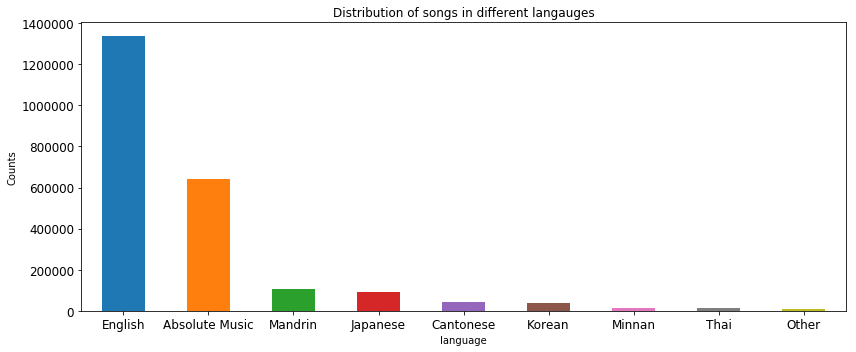

In [195]:
# get the distribution of songs in different languages
songs.language.value_counts().plot.bar(fontsize=12,figsize=[12,5])
plt.xlabel("language")
plt.ylabel("Counts")
plt.xticks(rotation='horizontal')
plt.title("Distribution of songs in different langauges")
plt.tight_layout()
plt.savefig("songs_language.png",bbox_inches="tight")

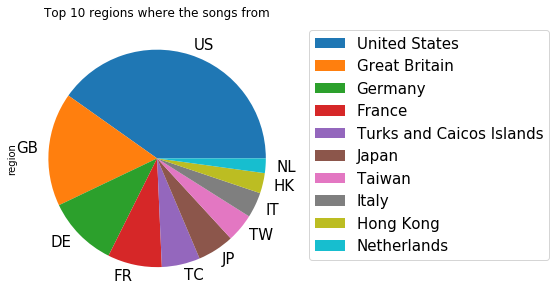

In [196]:
#top 10 regions
songs["region"].value_counts()[:10].plot.pie(fontsize=15)
plt.title("Top 10 regions where the songs from")
country_labels = ["United States","Great Britain","Germany","France","Turks and Caicos Islands", \
                  "Japan","Taiwan","Italy","Hong Kong","Netherlands"]
plt.legend(labels= country_labels,loc=9, bbox_to_anchor=(1.5,1),fontsize=15)
plt.savefig("top_regions.png",bbox_inches="tight")

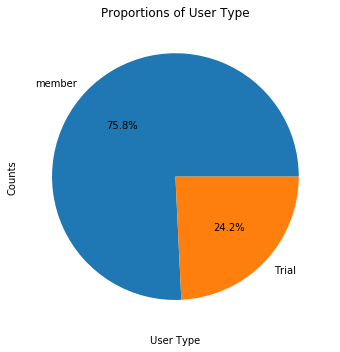

In [197]:
members["membership_duration"]=members["expiration_date"]-members["registration_init_time"]
# categorize users into formal or informal by their registration duration.
# formal if registration duration > 30 days, and vice versa
members["user_type"] = members["expiration_date"]-members["registration_init_time"] > pd.Timedelta(days=30)
members["user_type"] = members["user_type"].map(lambda x: "member" if x else "Trial")
members["user_type"].value_counts().plot.pie(autopct='%1.1f%%')
plt.xlabel("User Type")
plt.ylabel("Counts")
plt.xticks(rotation='horizontal')
plt.title("Proportions of User Type")
plt.tight_layout()
plt.savefig("user_type.png",bbox_inches="tight")

In [ ]:
# get the rate of repeating songs for each member from the training data
user_repeat_rate=train.groupby("msno")["target"].value_counts(normalize=True).unstack(fill_value=0)
user_repeat_rate.reset_index(inplace=True)
user_repeat_rate.rename(columns={1:'user_repeat_rate'}, inplace=True)
members = members.merge(user_repeat_rate[["msno",'user_repeat_rate']],how="left",on="msno")
members.head()

# get the rate of being repeated for each songs from the trainng data.
song_repeat_rate=train.groupby("song_id")["target"].value_counts(normalize=True).unstack(fill_value=0)
song_repeat_rate.reset_index(inplace=True)
song_repeat_rate.rename(columns={1:'song_repeat_rate'}, inplace=True)
songs = songs.merge(song_repeat_rate[["song_id",'song_repeat_rate']],how="left",on="song_id")
songs.head()

# top music in training data
top_songs = train["song_id"].value_counts()[:10]
top_songs.index = song_extra.set_index("song_id").loc[top_songs.index.tolist(),:]["name"]
top_songs

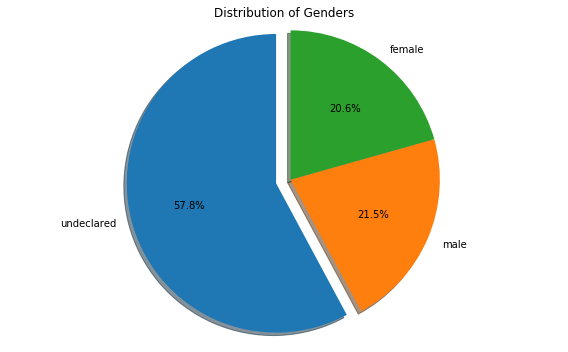

In [198]:
#get gender distribution
genders = members.gender.fillna("undeclared").value_counts()
fig1, ax1 = plt.subplots()
explode = (0.1, 0, 0)  
ax1.pie(genders, explode=explode, labels=genders.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Distribution of Genders")
plt.tight_layout()
plt.savefig("genders.png",bbox_inches="tight")

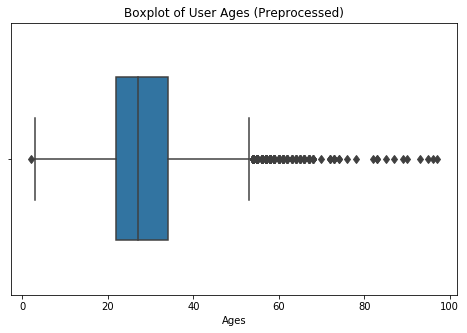

In [201]:
# boxplot of ages before excluding outliers
ages_without_zeros = members["bd"][(members["bd"]>0)&(members["bd"]<100)]
ax = sns.boxplot(x=ages_without_zeros, width=0.6,whis=1.6,fliersize=6)
plt.title("Boxplot of User Ages (Preprocessed)")
plt.xlabel("Ages")
ax.figure.savefig('age_box_pro.png',bbox_inches="tight")

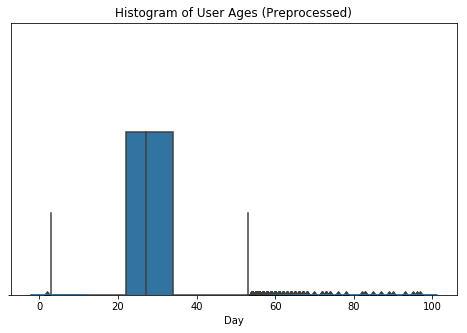

In [200]:
# age distibution
ages_without_zeros = members["bd"][(members["bd"]>0)&(members["bd"]<100)]
ax = sns.distplot(ages_without_zeros)
plt.title("Histogram of User Ages (Preprocessed)")
plt.xlabel("Day")
ax.figure.savefig('age_hist.png',bbox_inches="tight")

In [ ]:
# merge data
train = train.merge(songs,how="left",on=["song_id"])
train = train.merge(members, how="left",on=["msno"])

In [2]:
#subset data for logistic regression
log_data=train[["msno","song_id","artist_name_1","composer_1","source_screen_name","bd","source_type","user_type","lyricist_1","target"]]
log_data.fillna("NAN",inplace = True)
train_data,test_data = train_test_split(log_data,test_size=0.1)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [4]:
### Build a logistic classifier 
class logistic_classifer:
    def __init__(self,data):
        self.train_data = data
        # get rate of liking a song for each feature
        self.rates = dict()
        for i in self.train_data.columns[:-1]:
            self.rates[i] = self.train_data.groupby(i)["target"].value_counts(normalize=True).unstack(fill_value=0).to_dict()[1]
    
    # A function that mapped the rate of liking to the dataset
    def map_rates(self,data):
        def map_rate(row,col):
            try:
                result = self.rates[col][row]
            except KeyError:
                result = np.array(list(self.rates[col].values())).mean()
            return result

        mapped_data = []
        for i in data.columns[:-1]:
            temp = list(map(map_rate,data[i],[i]*len(data[i])))
            mapped_data.append(temp)
        x = np.array(mapped_data).transpose()
        y = data.iloc[:,-1].values
        return x,y
        
    # train on the training set
    def train(self,solver ='lbfgs'):
        self.train_x,self.train_y = self.map_rates(self.train_data)
        self.clf = LogisticRegression(random_state=0, solver= solver,multi_class='ovr').fit(self.train_x, self.train_y)
    # fit on a test set    
    def predict(self,test):
        self.test_x,self.test_y = self.map_rates(test)
        self.result = self.clf.predict(self.test_x)
        
log_clf = logistic_classifer(train_data)  
log_clf.train()
log_clf.predict(test_data)

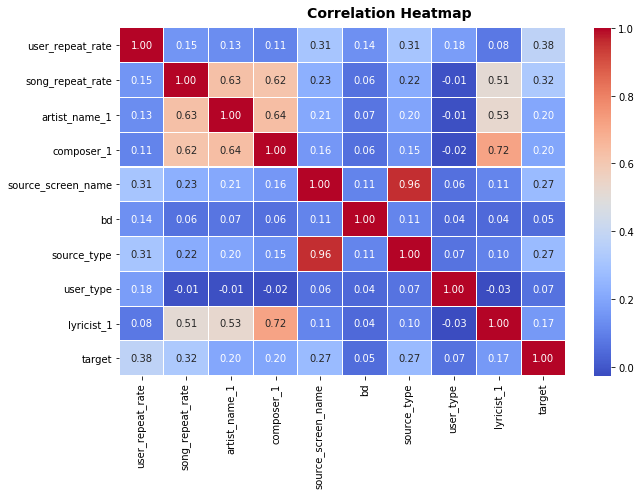

In [182]:
#Draw corelation heatmap
mapped_train_data = np.c_[log_clf.train_x,log_clf.train_y]
mapped_train_data=pd.DataFrame(mapped_train_data,columns=["user_repeat_rate","song_repeat_rate","artist_name_1","composer_1","source_screen_name","bd","source_type","user_type","lyricist_1","target"])

fig, (ax) = plt.subplots(1, 1, figsize=(10,6))
corr = mapped_train_data.corr()
hm = sns.heatmap(corr, 
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 #square=True,    # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=True, 
                 fmt='.2f',       # String formatting code to use when adding annotations.
                 #annot_kws={"size": 14},
                 linewidths=.05)

fig.subplots_adjust(top=0.93)
fig.suptitle('Correlation Heatmap', 
              fontsize=14, 
              fontweight='bold')

ax.figure.savefig('correlation.png',bbox_inches="tight")


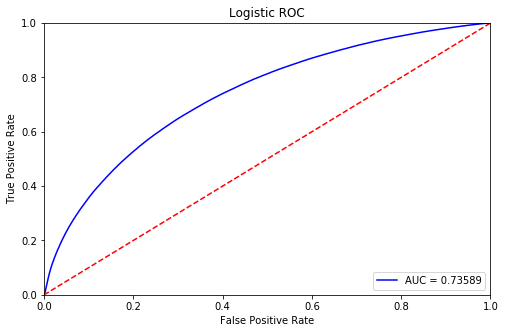

In [188]:
# draw AUROC for the model
# calculate the fpr and tpr for all thresholds of the classification
probs = log_clf.clf.predict_proba(log_clf.test_x)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(log_clf.test_y, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Logistic ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("log_roc.png",bbox_inches="tight")

In [52]:
#prepare data for lightgbm
X = train.drop(["msno","song_id","target",],axis=1)
X.registration_init_time = X['registration_init_time'].dt.day 
X.expiration_date= X["expiration_date"].dt.day
X.membership_duration=X.membership_duration.dt.days
df_cate=['source_system_tab', 'source_screen_name', 'source_type',
       'language', 'genre_ids_1', 'genre_ids_2', 'genre_ids_3', 'composer_1',
       'composer_2', 'composer_3', 'lyricist_1', 'lyricist_2', 'lyricist_3',
       'artist_name_1', 'artist_name_2', 'artist_name_3',"region",
       'city', 'bd', 'gender', 'registered_via', 'user_type','registration_init_time','expiration_date','membership_duration']
for cate in df_cate:
     X[cate] = X[cate].astype('category') 
y = train['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
d_train = lgb.Dataset(X_train, y_train)
d_valid = lgb.Dataset(X_test,y_test)

watchlist=[d_valid,d_train]

In [59]:
#lightgbm parameters
params = {}
params['learning_rate'] = 0.5
params['application'] = 'binary'
params['max_depth'] = 10
params['num_leaves'] = 2**6
params['verbosity'] = 0
params['metric'] = 'auc'
params["boosting type"] = "random_forest"

#training lightGBM
evals_result = {}
lgb_model = lgb.train(params, train_set=d_train, num_boost_round=500, valid_sets=watchlist,verbose_eval=20,\
                      evals_result=evals_result)

[20]	training's auc: 0.802847	valid_0's auc: 0.797082
[40]	training's auc: 0.811627	valid_0's auc: 0.801461
[60]	training's auc: 0.818415	valid_0's auc: 0.804626
[80]	training's auc: 0.825083	valid_0's auc: 0.807907
[100]	training's auc: 0.830817	valid_0's auc: 0.810354
[120]	training's auc: 0.835009	valid_0's auc: 0.811796
[140]	training's auc: 0.839066	valid_0's auc: 0.813235
[160]	training's auc: 0.842447	valid_0's auc: 0.814215
[180]	training's auc: 0.845813	valid_0's auc: 0.815316
[200]	training's auc: 0.848647	valid_0's auc: 0.81607
[220]	training's auc: 0.851224	valid_0's auc: 0.816504
[240]	training's auc: 0.853522	valid_0's auc: 0.816998
[260]	training's auc: 0.855598	valid_0's auc: 0.817304
[280]	training's auc: 0.858007	valid_0's auc: 0.817914
[300]	training's auc: 0.860057	valid_0's auc: 0.818242
[320]	training's auc: 0.861939	valid_0's auc: 0.818329
[340]	training's auc: 0.863434	valid_0's auc: 0.818489
[360]	training's auc: 0.865508	valid_0's auc: 0.818844
[380]	training'

In [23]:
# get feature_scors
feature_score = pd.DataFrame(lgb_model.feature_importance(), columns=['score'])
feature_score['feature'] = X_train.columns
feature_score = feature_score.sort_values(by=['score'], ascending=False)

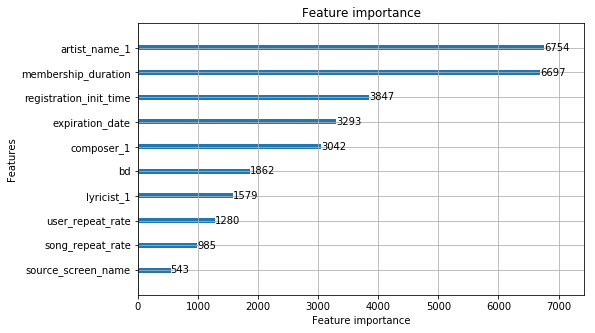

In [194]:
# plot feature importance
lgb.plot_importance(lgb_model, max_num_features=10)
plt.savefig("features.png",bbox_inches="tight")

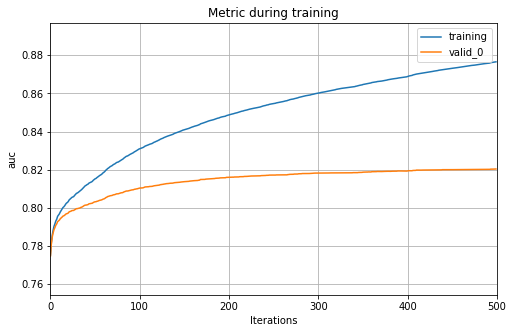

In [202]:
#plot AUC Score
lgb.plot_metric(evals_result, metric='auc')
plt.rcParams['figure.figsize'] = [8, 5]
plt.savefig("metric.png",bbox_inches="tight")

In [65]:
#data for matrix fatorization
target = train[["msno","song_id","target"]]
reader = surprise.Reader(rating_scale=(0,1))
user_item = surprise.Dataset.load_from_df(target,reader)

trainset,testset = surprise.model_selection.split.train_test_split(user_item)

In [127]:
#### train and fit FunK SVD
svd_result = []
K = [1,30,100]
for i in [1,30,100]:
    algo_SVD = surprise.SVD(n_factors = i)
    algo_SVD.fit(trainset)
    prediction_SVD = algo_SVD.test(testset)
    svd_result.append(prediction_SVD)

In [191]:
# function to draw AUROC 
def draw_AUROC(K ,predictions, algo):
    for k,prediction in zip(K,predictions):  
        prediction = np.array(list(map(list,prediction)))
        preds = prediction[:,3].astype(np.float)
        label = prediction[:,2].astype(np.float)
        fpr, tpr, threshold = metrics.roc_curve(label, preds)
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label = 'K=%d: %0.5f' % (k,roc_auc))
    plt.title(algo+' AUROC')
    plt.legend(loc = 'lower right',title = "AUC")
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig(algo+"_roc.png",bbox_inches="tight")

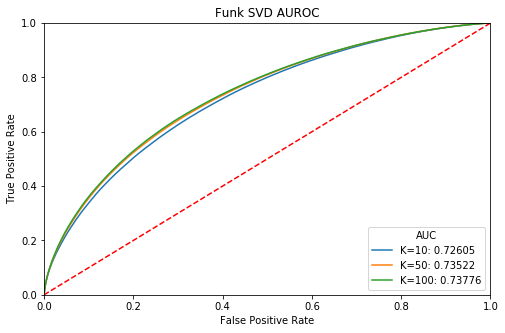

In [192]:
draw_AUROC(K,svd_result,"Funk SVD")

In [140]:
# train and fit NMF
NMF_result = []
K = [1,30,100]
for i in K:
    algo_NMF = surprise.NMF(n_factors = i)
    algo_NMF.fit(trainset)
    prediction_NMF = algo_NMF.test(testset)
    NMF_result.append(prediction_NMF)

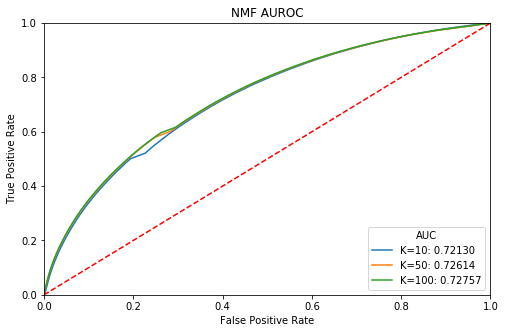

In [193]:
draw_AUROC(K,NMF_result, "NMF")

In [145]:
from tqdm import tqdm

In [146]:
# train and fit co-clustering
clustering_result = []
K = [10,50,100]
for i in tqdm(K):
    algo_clustering = surprise.CoClustering(n_cltr_i=i,n_cltr_u=i)
    algo_clustering.fit(trainset)
    prediction_clustering = algo_clustering.test(testset)
    clustering_result.append(prediction_clustering)


100%|██████████| 3/3 [46:59<00:00, 826.77s/it]


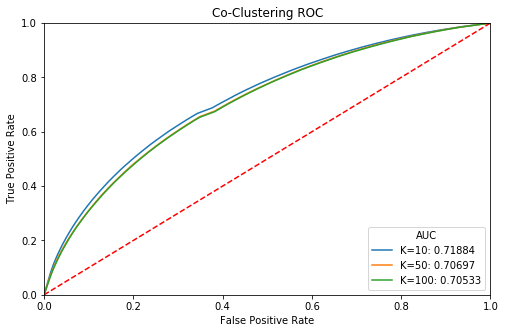

In [147]:
draw_AUROC(K,clustering_result, "Co-Clustering")

In [ ]:
###get recommandations 
from collections import defaultdict
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n
top_n = get_top_n(prediction_SVD, n=10)

In [ ]:
## get recommanded songs
predict_users = list(top_n.keys())
recommend_songs = pd.DataFrame()
for i in top_n[predict_users[50]]:
    recommend_songs = recommend_songs.append(pd.DataFrame(songs.loc[i[0]]).transpose())

recommend_songs

In [ ]:
####see what the user like before 
predict_user_history = train.loc[predict_users[50]]
songs_like_before = songs.loc[predict_user_history[predict_user_history.target==1].song_id]
songs_like_before